## Setup

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to C:\/Users/laara/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete86NHXO/imdb_reviews-train.tfrecord


Shuffling and writing examples to C:\/Users/laara/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete86NHXO/imdb_reviews-test.tfrecord


Shuffling and writing examples to C:\/Users/laara/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete86NHXO/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to C:\Users\laara\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [5]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [7]:
sample_string = 'Hi TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [1052, 7961, 6307, 2327, 4043, 2120, 7975]
The original string: "Hi TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

1052 ----> Hi
7961 ---->  
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Compile the Keras model to configure the training process:

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 2761s 7s/step - loss: 0.6246 - accuracy: 0.5804 - val_loss: 0.5126 - val_accuracy: 0.7281
Epoch 2/10
391/391 [==============================] - 1818s 5s/step - loss: 0.3251 - accuracy: 0.8640 - val_loss: 0.3426 - val_accuracy: 0.8646
Epoch 3/10
391/391 [==============================] - 1693s 4s/step - loss: 0.2397 - accuracy: 0.9068 - val_loss: 0.3265 - val_accuracy: 0.8724
Epoch 4/10
391/391 [==============================] - 1571s 4s/step - loss: 0.1997 - accuracy: 0.9260 - val_loss: 0.3330 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 1579s 4s/step - loss: 0.1776 - accuracy: 0.9346 - val_loss: 0.3406 - val_accuracy: 0.8656
Epoch 6/10
391/391 [==============================] - 1528s 4s/step - loss: 0.1572 - accuracy: 0.9442 - val_loss: 0.3621 - val_accuracy: 0.8693
Epoch 7/10
391/391 [==============================] - 1522s 4s/step - loss: 0.1413 - accuracy: 0.9519 - val_loss: 0.3905 - val_accuracy:

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 139s 357ms/step - loss: 0.4777 - accuracy: 0.8481
Test Loss: 0.47769203782081604
Test Accuracy: 0.8481199741363525


In [16]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [17]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [18]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.36116648]]


In [19]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.8280829]]


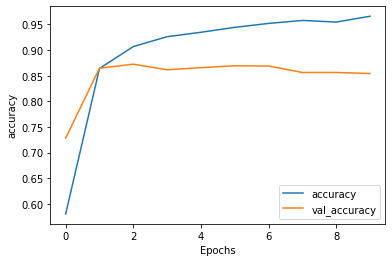

In [20]:
plot_graphs(history, 'accuracy')

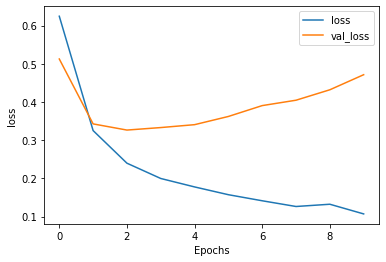

In [21]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 2583s 7s/step - loss: 0.6272 - accuracy: 0.5881 - val_loss: 0.4306 - val_accuracy: 0.8099
Epoch 2/10
391/391 [==============================] - 2604s 7s/step - loss: 0.3464 - accuracy: 0.8598 - val_loss: 0.3494 - val_accuracy: 0.8505
Epoch 3/10
391/391 [==============================] - 3351s 9s/step - loss: 0.2650 - accuracy: 0.9013 - val_loss: 0.3739 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 4015s 10s/step - loss: 0.2231 - accuracy: 0.9209 - val_loss: 0.3510 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 3447s 9s/step - loss: 0.1803 - accuracy: 0.9407 - val_loss: 0.3900 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 3473s 9s/step - loss: 0.1569 - accuracy: 0.9515 - val_loss: 0.3890 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 3222s 8s/step - loss: 0.1332 - accuracy: 0.9628 - val_loss: 0.4538 - val_accuracy

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 652s 2s/step - loss: 0.5358 - accuracy: 0.8482
Test Loss: 0.5358132123947144
Test Accuracy: 0.8482400178909302


In [26]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.7659922]]


In [27]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-4.1848235]]


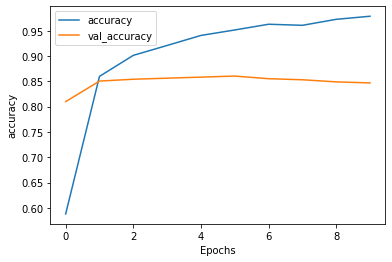

In [28]:
plot_graphs(history, 'accuracy')

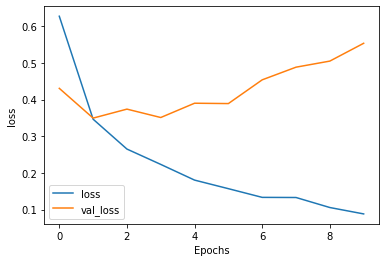

In [29]:
plot_graphs(history, 'loss')